# Demandlib Model Example
This notebook demonstrates how to use Demandlib space heating model to simulate heating loads for multiple buildings.

# Imports
Import required libraries and set visualization defaults.

In [30]:
import os
import sys
import time

import pandas as pd
import matplotlib.pyplot as plt

# Add project root
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../..")))

from entise.core.generator import Generator
from entise.constants import Types
from entise.constants import Columns as Cols

# repo root = two levels above examples/heat_demandlib
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# put repo root at the very front so it overrides site-packages
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

print("REPO_ROOT:", REPO_ROOT)

import entise
print("entise imported from:", entise.__file__)

REPO_ROOT: C:\Users\ge23nur\Documents\Python Scripts\TS_Creator
entise imported from: C:\Users\ge23nur\Documents\Python Scripts\TS_Creator\entise\__init__.py


# Load Data
We load building parameters from objects.csv and simulation data from the data folder.

In [31]:
# Load data
cwd = "."  # notebook runs inside examples/heat_demandlib

objects = pd.read_csv(os.path.join(cwd, "objects.csv"))

data = {}
common_data_folder = "../common_data"

for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(
            os.path.join(cwd, common_data_folder, file),
            parse_dates=True,
        )

print("Loaded data keys:", list(data.keys()))
print(f"📋 Loaded {len(objects)} objects")

Loaded data keys: ['validation_weather', 'weather']
📋 Loaded 10 objects


# Instantiate and Configure Model
Initialize the time series generator and configure it with building objects.

In [32]:
gen = Generator()
gen.add_objects(objects)

summary, df = gen.generate(data, workers=1)

100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


# Results Summary
Below is a summary of the annual heating demands (in kWh/a) and peak loads (W).

In [33]:
print("Summary:")
summary_kwh = (summary / 1000).round(0).astype(int)
summary_kwh.rename(columns=lambda x: x.replace("[W]", "[kW]").replace("[Wh]", "[kWh]"), inplace=True)
print(summary_kwh.to_string())

Summary:
    heating:demand[kWh]  heating:load_max[kW]
1                  5578                     2
2                  1701                     1
3                  1073                     0
4                 11792                     5
5                  3487                     1
6                 28220                    12
7                 23140                    10
8                  5180                     2
9                 23180                    10
10                10614                     4


# Preparation of Data

In [34]:
# Define the building ID to process and visualize
building_id = summary.index[0]  # Change index to visualize different buildings

# Visualize results for the processed building
# Note: We're using the same building_id as defined above
building_data = df[building_id][Types.HEATING]

# Visualization of Results
Visualize heatingloads for a selected building.

In [35]:
def plot_heating_loads():
    """Heating and Cooling Loads"""
    fig, ax = plt.subplots(figsize=(14, 5))
    heating_MWh = summary.loc[building_id, "heating:demand[Wh]"] / 1e6
    (line1,) = ax.plot(
        pd.to_datetime(building_data.index, utc=True),
        building_data["heating:load[W]"],
        label=f"Heating: {heating_MWh:.1f} MWh",
        color="tab:red",
        alpha=0.8,
    )
    # Create the combined legend in the upper left corner
    ax.set_ylabel("Load (W)")
    ax.set_title(f"Building ID: {building_id} - Heating Loads")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

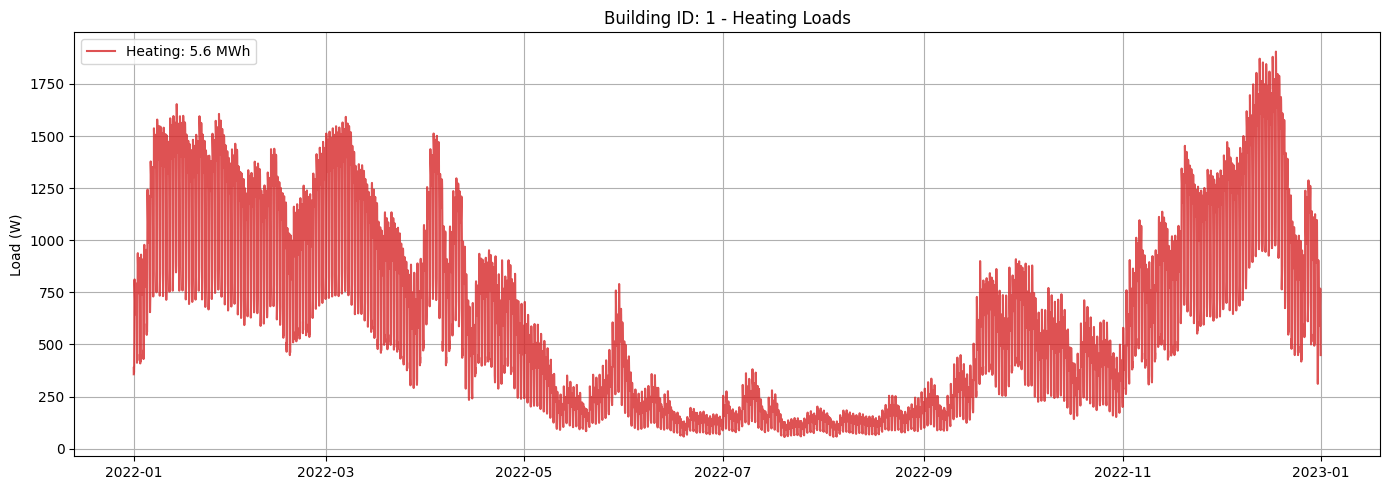

In [36]:
plot_heating_loads()

# Outdoor Temperature with Heating Loads
Next, we visualize the outdoor temperature alongside the heating loads to see how they correlate.

In [37]:
def plot_outdoor_temp_with_loads():
    """Outdoor Temperature with Heating & Cooling Loads"""
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot outdoor temperature on left y-axis
    air_temp = data["weather"][f"{Cols.TEMP_AIR}@2m"]
    ax1.plot(
        pd.to_datetime(building_data.index, utc=True), air_temp, label="Outdoor Temp", color="tab:cyan", alpha=0.7
    )

    ax1.set_ylabel("Outdoor Temp (°C)")
    ax1.set_ylim(air_temp.min().round() - 2, air_temp.max().round() + 2)

    # Create second y-axis for loads
    ax2 = ax1.twinx()
    ax2.plot(
        pd.to_datetime(building_data.index, utc=True),
        building_data["heating:load[W]"],
        label="Heating Load",
        color="tab:red",
        alpha=0.8,
    )
    ax2.set_ylabel("HVAC Load (W)")
    ax2.set_ylim(
        building_data["heating:load[W]"].min() * 1.1,
        building_data["heating:load[W]"].max() * 1.1,
    )

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax1.set_title(f"Building ID: {building_id} - Outdoor Temp & Heating Loads")
    ax1.grid(True)
    fig.tight_layout()
    plt.show()

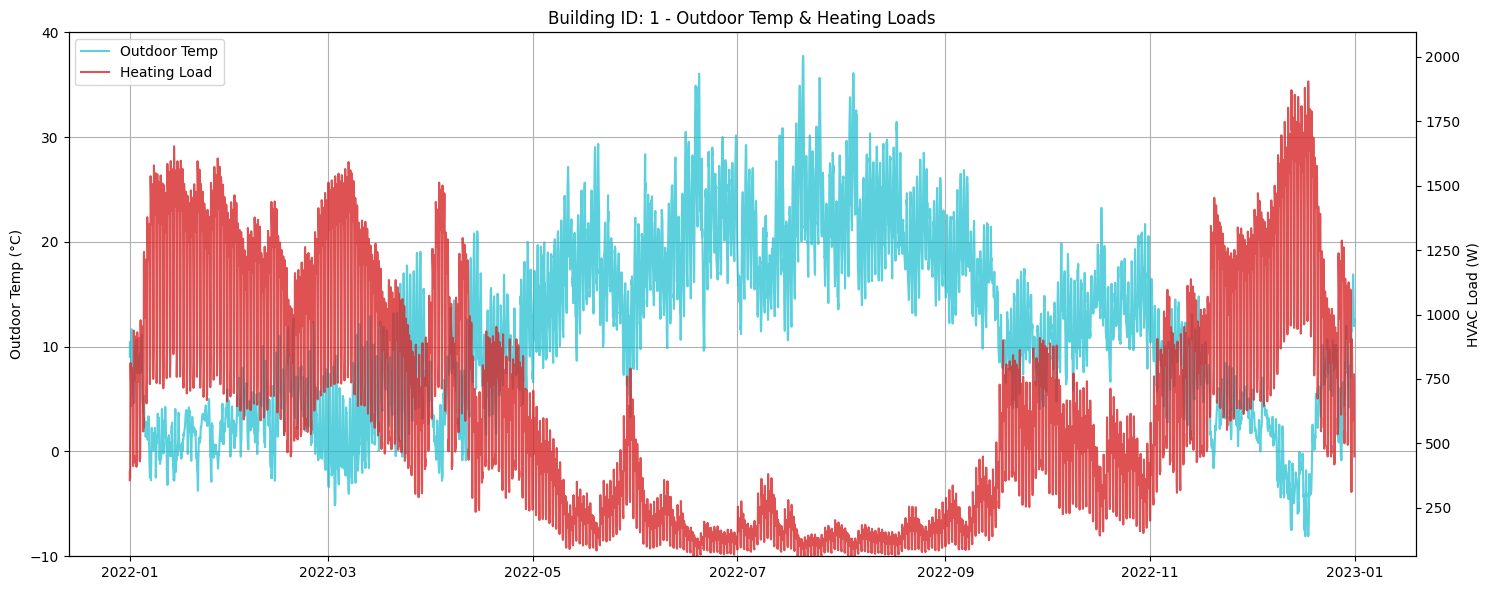

In [38]:
plot_outdoor_temp_with_loads()